# GRUPO 6
# Detección de anomalías en Ciberataques
Integrantes:
Bryan Alvarado • Diego Arámbulo • Jesús Zambrano

# 2. Instalación de librerías


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

# 3. Cargar Dataset

In [7]:
import glob
import pandas as pd
from google.colab import files

# 1. URL pública del archivo CSV
url = "https://drive.google.com/uc?id=16G0p0_DYZXyteQRUrqc0IWn_MkPTyX8A&export=download"

# 2. Cargar el CSV directamente desde la URL
data = pd.read_csv(url)

# 3. Renombrar la columna 'evil' a 'Label' (columna de verdad terreno)
data.rename(columns={'evil': 'Label'}, inplace=True)

# 4. Confirmacion de las estadisticas basicas
print(f"Total rows: {len(data)}")
print("Columns:", data.columns.tolist())
print("Class distribution:\n", data['Label'].value_counts())

Total rows: 21223
Columns: ['timestamp', 'processId', 'parentProcessId', 'userId', 'processName', 'hostName', 'eventId', 'eventName', 'argsNum', 'returnValue', 'args', 'sus', 'Label']
Class distribution:
 Label
0    16829
1     4394
Name: count, dtype: int64


# Preprocesamiento

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# 1. Eliminamos las columnas no relevantes de forma segura (dejamos solo las de tipo numericas, si deseamos alguna otra, debe pasar por la transformacion correspondiente)
drop_cols = ['timestamp', 'processName', 'hostName', 'eventName', 'stackAddresses', 'args', 'parentProcessId', 'userId', 'argsNum', 'returnValue']
existing_cols = [col for col in drop_cols if col in data.columns]
data = data.drop(columns=existing_cols)

# 2. Separamos etiquetas de caracteristicas
X = data.drop(columns=['Label']).values
y = data['Label'].values

# 3. Separacion de entrenamiento y validacion (80-20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Estandarizacion de caracteristicas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 5. Oversample de la clase ataque
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# 6. Conversion a tensors de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.float32).unsqueeze(1).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

# 7. DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
print(data)

       processId  eventId  sus  Label
0           7611      257    0      0
1           7852      257    0      0
2            159        5    0      0
3           7493        3    0      0
4              1        3    0      0
...          ...      ...  ...    ...
21218       7687        4    1      0
21219       7489      257    0      0
21220       7590     1005    0      0
21221       7644        3    1      1
21222       7917     1005    0      0

[21223 rows x 4 columns]


Primeras 5 filas del dataset:
   processId  eventId  sus  Label
0       7611      257    0      0
1       7852      257    0      0
2        159        5    0      0
3       7493        3    0      0
4          1        3    0      0

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21223 entries, 0 to 21222
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   processId  21223 non-null  int64
 1   eventId    21223 non-null  int64
 2   sus        21223 non-null  int64
 3   Label      21223 non-null  int64
dtypes: int64(4)
memory usage: 663.3 KB
None

Estadísticas descriptivas:
          processId       eventId           sus         Label
count  21223.000000  21223.000000  21223.000000  21223.000000
mean    6930.539226    296.462093      0.400038      0.207040
std     2342.358588    395.724417      0.489917      0.405194
min        1.000000      3.000000      0.000000      0.000000
25%     7488.000000  

<Figure size 1200x800 with 0 Axes>

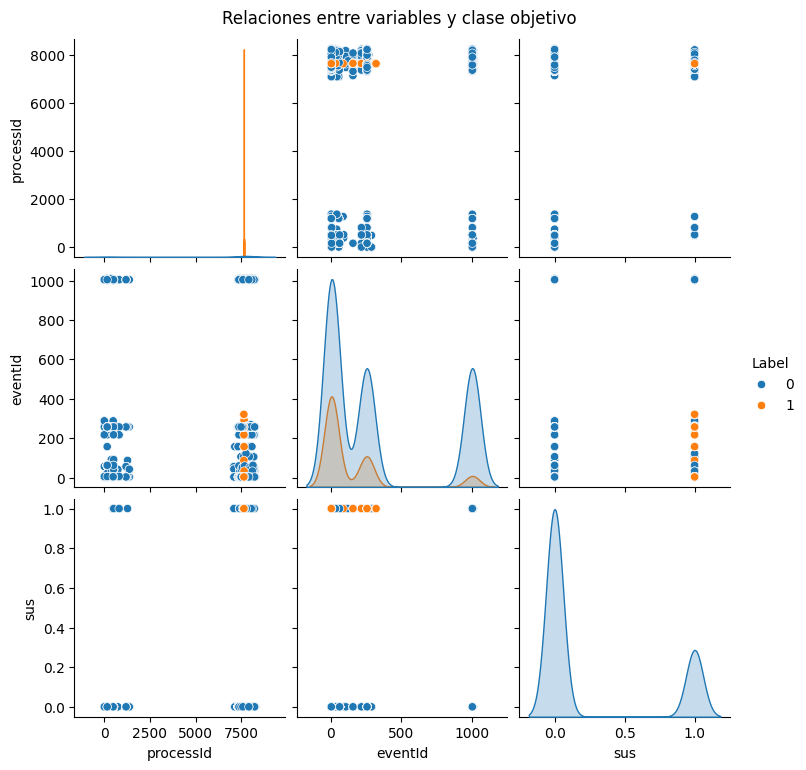

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Primeras 5 filas del dataset:")
print(data.head())

print("\nInformación del dataset:")
print(data.info())

print("\nEstadísticas descriptivas:")
print(data.describe())

# Visualización de correlaciones
plt.figure(figsize=(12, 8))
sns.pairplot(data, hue='Label')
plt.suptitle('Relaciones entre variables y clase objetivo', y=1.02)
plt.savefig('pairplot.png')  # Guardar figura para referencia
plt.show()

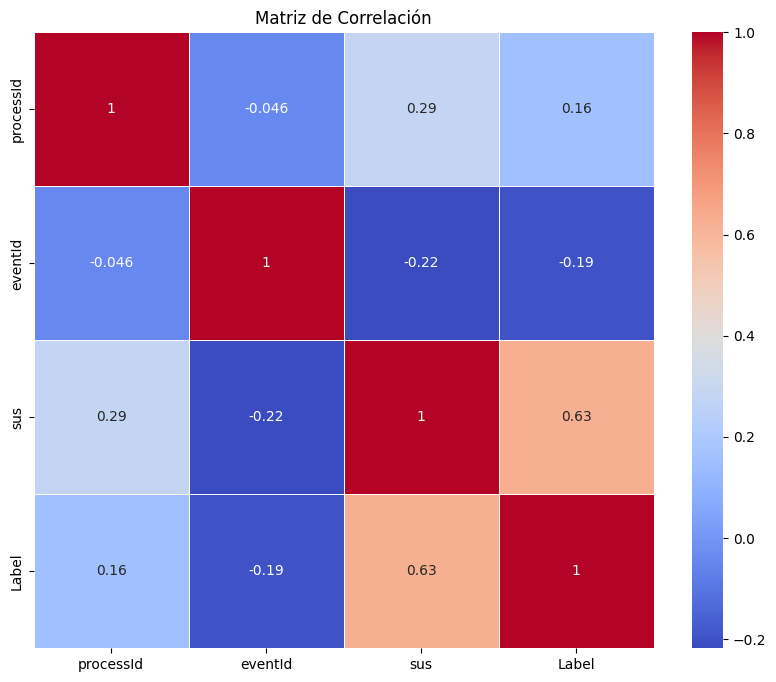

In [10]:
# Matriz de correlación (solo con columnas numéricas)
plt.figure(figsize=(10, 8))
# Seleccionamos solo columnas numéricas para la correlación
numeric_df = data.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.savefig('correlation_matrix.png')
plt.show()

In [11]:
# Alineacion de ejes para su comparativa
X = data[['sus', 'eventId']]
y = data['Label']

In [12]:
# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (16978, 2)
Tamaño del conjunto de prueba: (4245, 2)



MODELO 1: REGRESIÓN LOGÍSTICA

Matriz de Confusión (Regresión Logística):
[[2815  529]
 [ 282  619]]


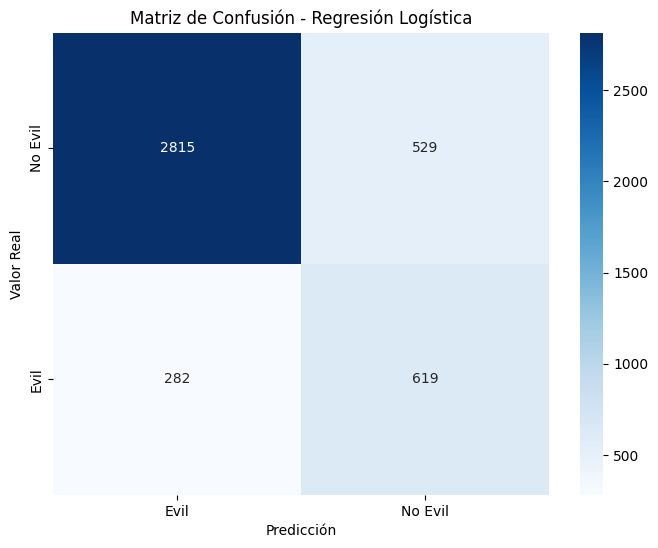


Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3344
           1       0.54      0.69      0.60       901

    accuracy                           0.81      4245
   macro avg       0.72      0.76      0.74      4245
weighted avg       0.83      0.81      0.82      4245


Coeficientes del modelo de Regresión Logística:
Intercept: -5.1018
Coeficiente para Evil (maligno): 4.1311
Coeficiente para No Evil (Benigno): -0.3699


In [14]:
# Implementación de Regresión Logística
print("\n" + "="*50)
print("MODELO 1: REGRESIÓN LOGÍSTICA")
print("="*50)

# Entrenamiento del modelo
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr.predict(X_test)

# Evaluación
print("\nMatriz de Confusión (Regresión Logística):")
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print(conf_matrix_lr)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Evil', 'No Evil'],
            yticklabels=['No Evil', 'Evil'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.savefig('confusion_matrix_lr.png')
plt.show()

print("\nReporte de Clasificación (Regresión Logística):")
print(classification_report(y_test, y_pred_lr))

# Coeficientes del modelo
print("\nCoeficientes del modelo de Regresión Logística:")
print(f"Intercept: {lr.intercept_[0]:.4f}")
print(f"Coeficiente para Evil (maligno): {lr.coef_[0][0]:.4f}")
print(f"Coeficiente para No Evil (Benigno): {lr.coef_[0][1]:.4f}")


MODELO 2: SUPPORT VECTOR MACHINE (SVM)

Matriz de Confusión (SVM):
[[2677  667]
 [  83  818]]


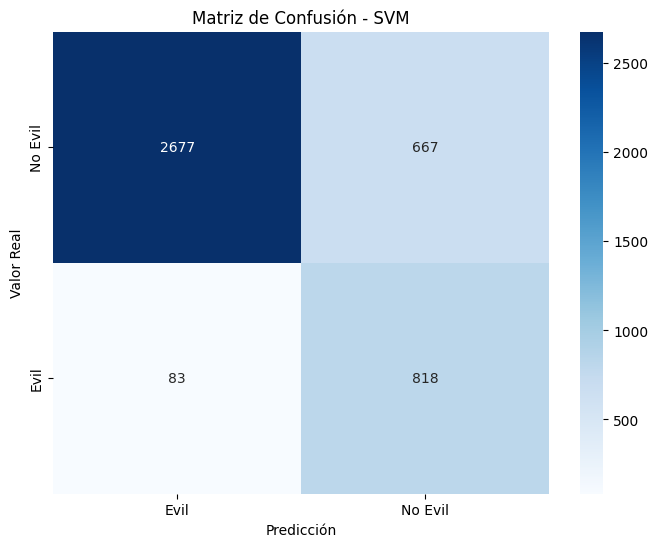


Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      3344
           1       0.55      0.91      0.69       901

    accuracy                           0.82      4245
   macro avg       0.76      0.85      0.78      4245
weighted avg       0.88      0.82      0.84      4245



In [16]:
# 5. Implementación de SVM (Support Vector Machine)
print("\n" + "="*50)
print("MODELO 2: SUPPORT VECTOR MACHINE (SVM)")
print("="*50)

# Entrenamiento del modelo
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# Predicciones
y_pred_svm = svm.predict(X_test)

# Evaluación
print("\nMatriz de Confusión (SVM):")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix_svm)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Evil', 'No Evil'],
            yticklabels=['No Evil', 'Evil'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - SVM')
plt.savefig('confusion_matrix_svm.png')
plt.show()

print("\nReporte de Clasificación (SVM):")
print(classification_report(y_test, y_pred_svm))


MODELO 3: ÁRBOL DE DECISIÓN

Matriz de Confusión (Árbol de Decisión):
[[2997  347]
 [ 270  631]]


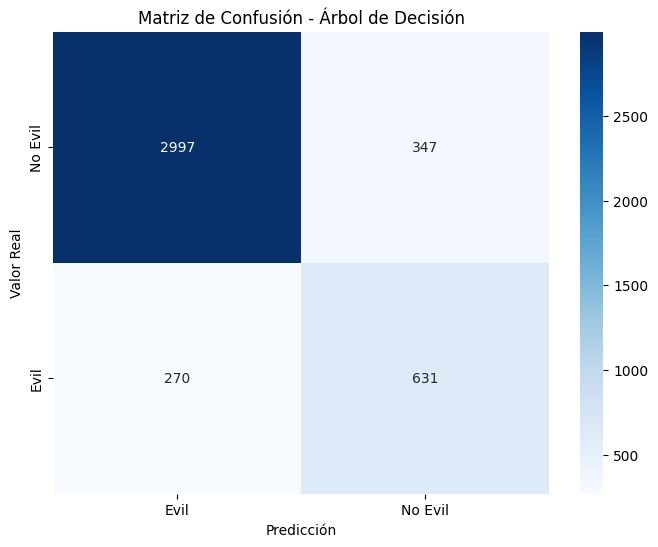


Reporte de Clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3344
           1       0.65      0.70      0.67       901

    accuracy                           0.85      4245
   macro avg       0.78      0.80      0.79      4245
weighted avg       0.86      0.85      0.86      4245


Importancia de características (Árbol de Decisión):
Importancia de sus (suspect): 0.8166
Importancia de event ID: 0.1834


In [17]:
# 6. Implementación de Árbol de Decisión
print("\n" + "="*50)
print("MODELO 3: ÁRBOL DE DECISIÓN")
print("="*50)

# Entrenamiento del modelo
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree.predict(X_test)

# Evaluación
print("\nMatriz de Confusión (Árbol de Decisión):")
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
print(conf_matrix_tree)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Evil', 'No Evil'],
            yticklabels=['No Evil', 'Evil'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.savefig('confusion_matrix_tree.png')
plt.show()

print("\nReporte de Clasificación (Árbol de Decisión):")
print(classification_report(y_test, y_pred_tree))

# Importancia de características
print("\nImportancia de características (Árbol de Decisión):")
print(f"Importancia de sus (suspect): {tree.feature_importances_[0]:.4f}")
print(f"Importancia de event ID: {tree.feature_importances_[1]:.4f}")


COMPARACIÓN DE MODELOS CON VALIDACIÓN CRUZADA
Regresión Logística: Accuracy promedio = 0.822, Desviación Estándar = 0.006
SVM: Accuracy promedio = 0.825, Desviación Estándar = 0.007
Árbol de Decisión: Accuracy promedio = 0.858, Desviación Estándar = 0.008

Resumen de validación cruzada:
                Modelo  Accuracy Promedio  Desviación Estándar
0  Regresión Logística           0.821938             0.006399
1                  SVM           0.825472             0.007327
2    Árbol de Decisión           0.857842             0.007918


/tmp/ipython-input-254775568.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Accuracy Promedio', data=cv_df, palette='viridis')


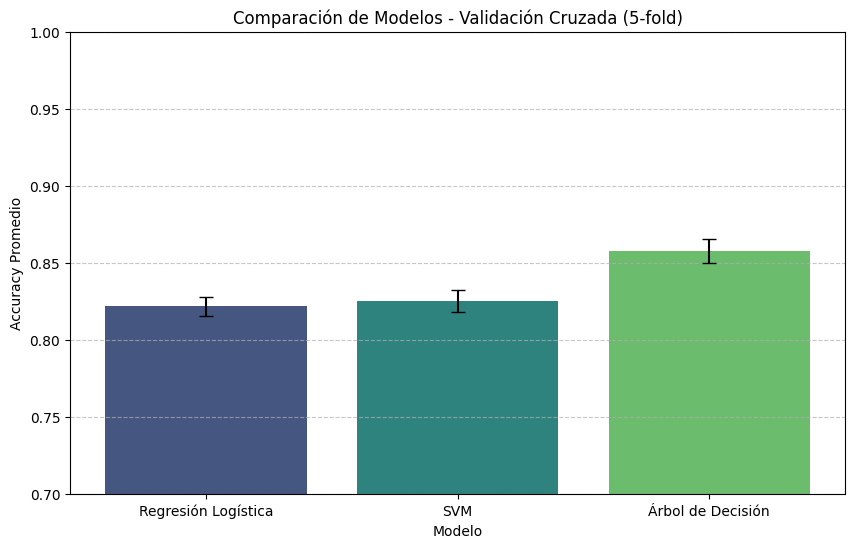

In [18]:
# 7. Comparación de modelos con validación cruzada
print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS CON VALIDACIÓN CRUZADA")
print("="*50)

models = {
    'Regresión Logística': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'Árbol de Decisión': DecisionTreeClassifier(max_depth=4, random_state=42)
}

# Lista para almacenar resultados
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    cv_results.append({
        'Modelo': name,
        'Accuracy Promedio': scores.mean(),
        'Desviación Estándar': scores.std(),
        'Scores': scores
    })
    print(f"{name}: Accuracy promedio = {scores.mean():.3f}, Desviación Estándar = {scores.std():.3f}")

# Visualización de resultados de validación cruzada
cv_df = pd.DataFrame(cv_results)[['Modelo', 'Accuracy Promedio', 'Desviación Estándar']]
print("\nResumen de validación cruzada:")
print(cv_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Accuracy Promedio', data=cv_df, palette='viridis')
plt.errorbar(x=range(len(cv_df)), y=cv_df['Accuracy Promedio'],
             yerr=cv_df['Desviación Estándar'], fmt='none', color='black', capsize=5)
plt.title('Comparación de Modelos - Validación Cruzada (5-fold)')
plt.ylim(0.7, 1.0)  # Ajustar según los resultados
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('cross_validation_comparison.png')
plt.show()


VISUALIZACIÓN DE FRONTERAS DE DECISIÓN
Preparando visualización con 2 dimensiones (sus (suspect) y eventId)...
Generando visualizaciones de fronteras de decisión...


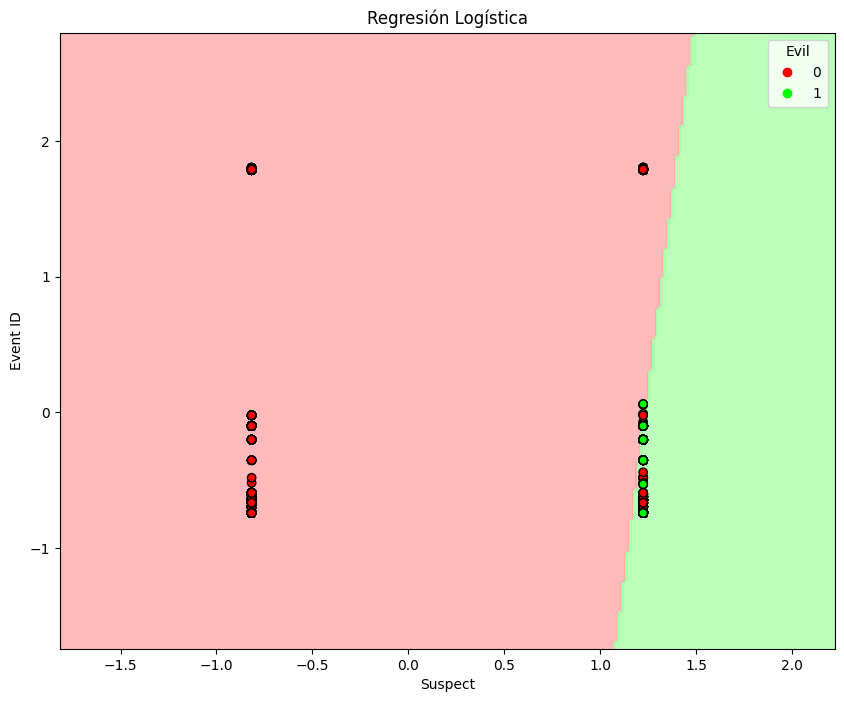

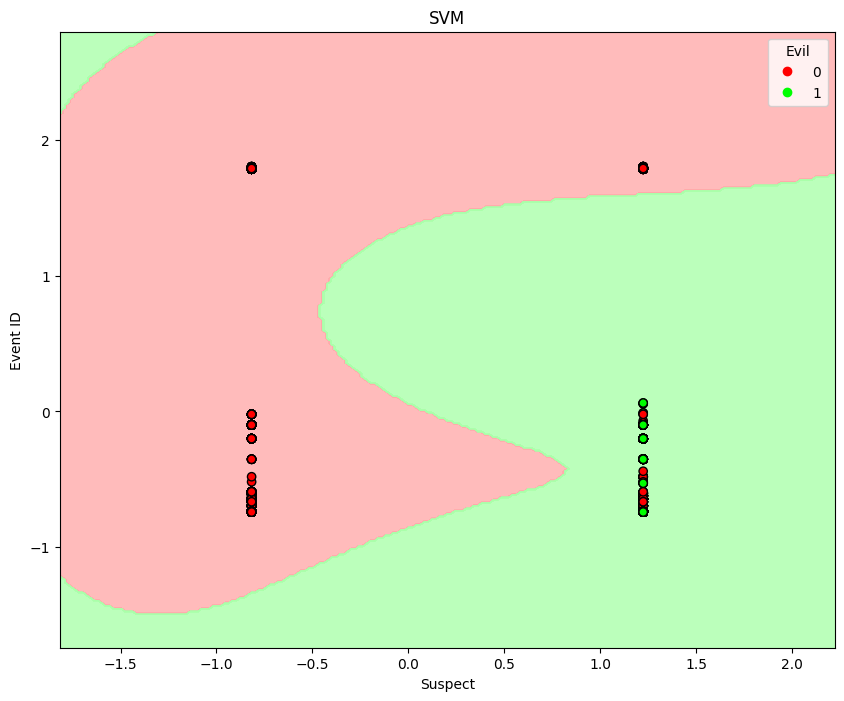

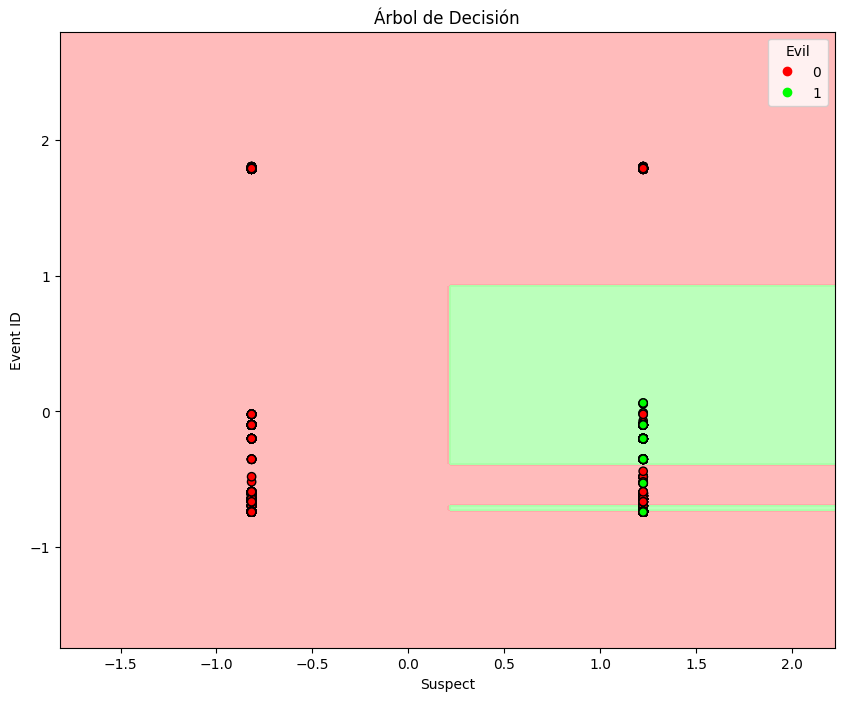


RESPUESTAS A LAS PREGUNTAS TÉCNICAS Y DE INTERPRETACIÓN


In [20]:
# 8. Visualización de fronteras de decisión
print("\n" + "="*50)
print("VISUALIZACIÓN DE FRONTERAS DE DECISIÓN")
print("="*50)

# Para visualizar las fronteras de decisión, usaremos solo sus y eventId
print("Preparando visualización con 2 dimensiones (sus (suspect) y eventId)...")

# Entrenamos nuevos modelos con solo 2 características pero usando los mismos datos de entrenamiento
# Seleccionamos solo sus y eventId del conjunto de entrenamiento
X_train_2d = X_train[:, -2:] if X_train.shape[1] > 2 else X_train

# Entrenamos modelos con solo 2 dimensiones para la visualización
lr_2d = LogisticRegression(random_state=42)
svm_2d = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
tree_2d = DecisionTreeClassifier(max_depth=4, random_state=42)

# Entrenamos estos modelos simplificados
lr_2d.fit(X_train_2d, y_train)
svm_2d.fit(X_train_2d, y_train)
tree_2d.fit(X_train_2d, y_train)

def plot_decision_boundary(model, X, y, title):
    h = 0.02  # Tamaño del paso en la malla
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predecir con el modelo
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAFFAA']))

    # Graficar los puntos de entrenamiento
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y,
                         edgecolors='k', cmap=ListedColormap(['#FF0000', '#00FF00']))

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('Suspect')
    plt.ylabel('Event ID')
    plt.legend(*scatter.legend_elements(), title="Evil")
    plt.savefig(f'decision_boundary_{title.replace(" ", "_").lower()}.png')
    plt.show()

# Obtenemos datos de X_scaled pero solo las últimas 2 columnas (sus y eventId)
X_2d_vis = X_scaled[:, -2:] if X_scaled.shape[1] > 2 else X_scaled

# Visualizar fronteras de decisión para cada modelo (usando solo 2 dimensiones)
print("Generando visualizaciones de fronteras de decisión...")
plot_decision_boundary(lr_2d, X_2d_vis, y, "Regresión Logística")
plot_decision_boundary(svm_2d, X_2d_vis, y, "SVM")
plot_decision_boundary(tree_2d, X_2d_vis, y, "Árbol de Decisión")

# Respuestas a las preguntas técnicas y de interpretación
print("\n" + "="*50)
print("RESPUESTAS A LAS PREGUNTAS TÉCNICAS Y DE INTERPRETACIÓN")
print("="*50)

In [21]:
from collections import Counter
print(Counter(y_train_balanced))  # This will tell you if 0s and 1s are balanced

Counter({np.int64(0): 13463, np.int64(1): 13463})
